# liamometer modeling 

    - Completed EDA, data cleaning
    - Made helper functions
    
    Now:
    
    - Run a series of feature engineering -> linear regression modeling (score on train and test) of:
        - OHE of genre;
        - OHE of genre ++ genre-genre interaction terms;
        - OHE of genre ++ genre-genre interaction terms ++ OHE of distributor;
        - Polynomial regression (deg=2) of OHE ofgenre ++ genre-genre interaction terms ++ OHE of distributor
        
    - Decide on model

In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

from prettytable import PrettyTable

In [2]:
from functions import get_clean_data, one_hot_encode, create_interactions, mae, replace_, run_linear

In [96]:
mojo = pd.read_csv('data/mojo.csv')
imdb = pd.read_csv('data/imdb.csv')

df = get_clean_data(mojo, imdb)

In [97]:
df = one_hot_encode('genres', df)
print("Genre one hot encoded")

Genre one hot encoded


/Users/liamisaacs/Desktop/github repositories/metis-project2/functions.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[option] = df[x].str.contains(option).astype('int')
/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [98]:
#Train-test split
X, y = df, df['imdbscore']

X.drop(columns=['imdbscore'], inplace=True)
X['domestic_international_ratio'] = X['domestic_revenue'] / X['international_revenue']
X['domestic_international_ratio'].fillna(value=0, inplace=True)
X['opening_revenue'].fillna(value=0, inplace=True)

#Division for ratio creates a float; opening revenue naturally is a float 
#We convert to integer like this
for col in ['domestic_international_ratio', 'opening_revenue']:
    X[col] = X[col].astype(int)

X.drop(columns=['mojo_title', 'international_revenue', 'domestic_revenue'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state =10)

### Baseline linear regression just on one-hot-encoded genre

In [99]:
print("Running baseline linear regression while ignoring distributor, world_revenue...")
X_TrainBaseline = X_train.iloc[:, 2:]
X_TestBaseline = X_test.iloc[:, 2:]

print("\nTrain")
run_linear(X_TrainBaseline, y_train)

print("\nTest")
run_linear(X_TestBaseline, y_test)

Running baseline linear regression while ignoring distributor, world_revenue...

Train
Linear regression val R^2: 0.094

Test
Linear regression val R^2: 0.173


### Baseline linear regression on OHE genre + interactions btwn genres

In [100]:
X_TrainBaselineInteractions = create_interactions(X_TrainBaseline)
X_TestBaselineInteractions = create_interactions(X_TestBaseline)
print("Interactions between genres done")

Interactions between genres done


In [101]:
print("Running baseline with interactions")


"""
This is what 'run_linear' is doing:

print("Scaling...")
scaler = preprocessing.StandardScaler()
X_TrainBaselineInteractionsScaled = scaler.fit_transform(X_TrainBaselineInteractions)
X_TestBaselineInteractionsScaled = scaler.fit_transform(X_TestBaselineInteractions)

lm2 = LinearRegression()
lm2.fit(X_TrainBaselineInteractionsScaled, y_train)
print(f'Linear regression (TRAINING DATA) with genre-genre interaction terms val R^2: {lm2.score(X_TrainBaselineInteractionsScaled, y_train):.3f}')
lm2.fit(X_TestBaselineInteractionsScaled, y_test)
print(f'Linear regression (TEST DATA) with genre-genre interaction terms val R^2: {lm2.score(X_TestBaselineInteractionsScaled, y_test):.3f}')
"""

print("\nTrain")
run_linear(X_TrainBaselineInteractions, y_train)

print("\nTest")
run_linear(X_TestBaselineInteractions, y_test)


Running baseline with interactions

Train
Linear regression val R^2: 0.184

Test
Linear regression val R^2: 0.330


### Baseline linear reg + OHE genre + genre-genre interactions ++ OHE distributor

In [102]:
print("Merge back in iteractions to X_trian")
X_train = X_train.merge(X_TrainBaselineInteractions.iloc[:, 26:380], how='inner', left_index=True, right_index=True)
X_test = X_test.merge(X_TestBaselineInteractions.iloc[:, 26:380], how='inner', left_index=True, right_index=True)

print("One hot encode distributor")
X_TrainBaselinev2 = one_hot_encode('distributor', X_train)
X_TestBaselinev2 = one_hot_encode('distributor', X_test)
print("Distributor is one-hot-encoded now too")

Merge back in iteractions to X_trian
One hot encode distributor


/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Distributor is one-hot-encoded now too


In [103]:
print("Scaling data since data is sensitive to magnitude.. (world_revenue is in the millions, IMDB rating is 1-10)")
scaler = preprocessing.StandardScaler()
X_TrainBaselinev2Scaled = scaler.fit_transform(X_TrainBaselinev2)
X_TestBaselinev2Scaled = scaler.fit_transform(X_TestBaselinev2)

lm = LinearRegression()
lm.fit(X_TrainBaselinev2, y_train)
print(f'Linear regression (on TRAINING DATA) with genre-genre interaction terms AND OHE of distributor val R^2: {lm.score(X_TrainBaselinev2, y_train):.3f}')
lm.fit(X_TestBaselinev2, y_test)
print(f'Linear regression (on TEST DATA) with genre-genre interaction terms AND OHE of distributor val R^2: {lm.score(X_TestBaselinev2, y_test):.3f}')

Scaling data since data is sensitive to magnitude.. (world_revenue is in the millions, IMDB rating is 1-10)
Linear regression (on TRAINING DATA) with genre-genre interaction terms AND OHE of distributor val R^2: 0.324
Linear regression (on TEST DATA) with genre-genre interaction terms AND OHE of distributor val R^2: 0.531


### Polynomial (degree=2) regression on (baseline linear reg + OHE genre + genre-genre interafctions + OHE distributor)

In [104]:
"""
Currently cannot run polynomial regression due to CPU overload.

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2, interaction_only = True)

X_train_poly = poly.fit_transform(X_TrainBaselinev2.values)
X_test_poly = poly.fit_transform(X_TestBaselinev2.values)

lm_poly = LinearRegression()
lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial (TRAINING DATA) regression val R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
lm_poly.fit(X_test_poly, y_test)
print(f'Degree 2 polynomial (TEST DATA) regression val R^2: {lm_poly.score(X_test_poly, y_test):.3f}')
"""
print("Currently cannot run polynomial regression due to CPU overload.")

Currently cannot run polynomial regression due to CPU overload.


In [105]:
scores = PrettyTable()
scores.field_names = ["Model", "Tr R^2", "Te R^2"]
scores.add_row(["OHE genre", 0.094, 0.173])
scores.add_row(["OHE genre ++ genre-genre interactions", 0.183, 0.320])
scores.add_row(["OHE genre + genre-genre interactions + OHE distributor", 0.324, 0.532])
print(scores)
print("R^2 highest for last model, will use that model.")

+--------------------------------------------------------+--------+--------+
|                         Model                          | Tr R^2 | Te R^2 |
+--------------------------------------------------------+--------+--------+
|                       OHE genre                        | 0.094  | 0.173  |
|         OHE genre ++ genre-genre interactions          | 0.183  |  0.32  |
| OHE genre + genre-genre interactions + OHE distributor | 0.324  | 0.532  |
+--------------------------------------------------------+--------+--------+
R^2 highest for last model, will use that model.


In [106]:
import pandas as pd

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot

from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

In [124]:
__ = X_TrainBaselinev2Scaled
_  = X_TestBaselinev2Scaled
__ = __.astype(np.float)
_ = _.astype(np.float)

TypeError: unsupported operand type(s) for -: 'float' and 'str'

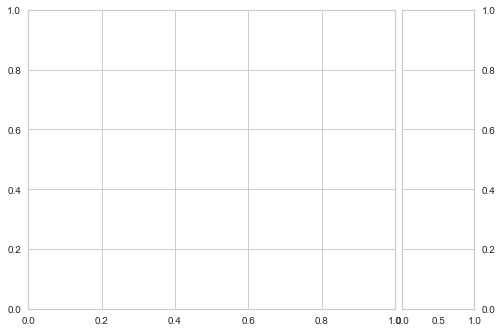

In [129]:
ridge_cv_5_fold = RidgeCV(cv=5)
visualizer = ResidualsPlot(ridge_cv_5_fold, hist=True)
visualizer.fit(__, y_train)  # Fit the training data to the visualizer
visualizer.score(_, y_test)  # Score on our test data
visualizer.show()                     # Finalize and render the figure